# Data preparation

We combine the data, convert the labels for classification and apply augmentation

In [1]:
import os, sys, math, json
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

np.random.seed(0)

IMAGE_SIZE = [32, 32]

Tensorflow version 2.6.0


In [2]:
df = pd.read_json('prepared-samples-binary.json')

y = df['label'].to_numpy()
X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [3]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [10]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
# y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
# y = fire_module(64, 128)(y)
# y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
# y = fire_module(48, 96)(y)
# y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
# y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)

model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 32, 32)   128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 32)   0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

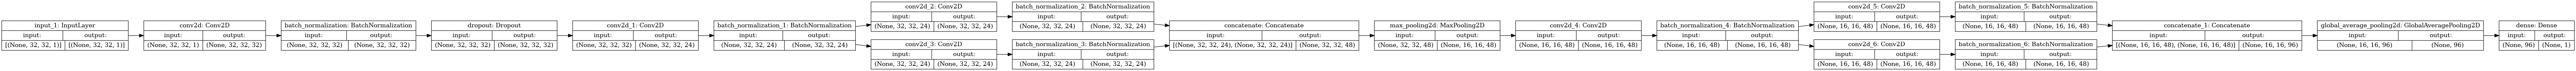

In [5]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Epoch 1/3
5/5 [==============================] - 1s 212ms/step - loss: 0.6160 - accuracy: 0.6500 - val_loss: 4.2500 - val_accuracy: 0.3000
Epoch 2/3
5/5 [==============================] - 1s 164ms/step - loss: 0.6135 - accuracy: 0.6375 - val_loss: 1.2575 - val_accuracy: 0.3000
Epoch 3/3
5/5 [==============================] - 1s 194ms/step - loss: 0.5901 - accuracy: 0.6750 - val_loss: 1.7571 - val_accuracy: 0.3000


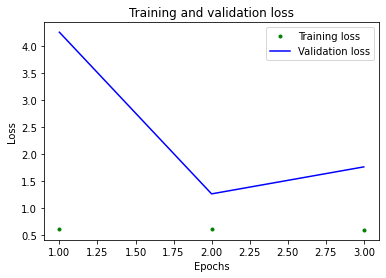

Test loss: 1.876260757446289 / Test accuracy: 0.30000001192092896


In [8]:
# Fit the model
EPOCHS = 3
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("squeezenet-eval.png")
plt.show()

# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

[[0.90856886]
 [0.9382176 ]
 [0.91886777]
 [0.9119895 ]
 [0.90732074]
 [0.9660698 ]
 [0.97853446]
 [0.91457146]
 [0.9766129 ]
 [0.91323495]
 [0.8876693 ]
 [0.913097  ]
 [0.9179441 ]
 [0.9246212 ]
 [0.91253674]
 [0.96906936]
 [0.96793664]
 [0.98558336]
 [0.9382176 ]
 [0.92341745]]


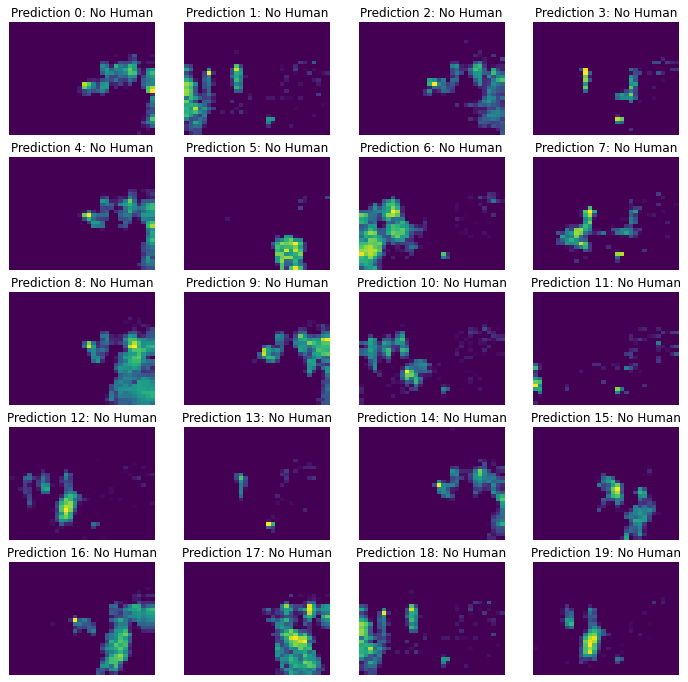

In [9]:
# make and show single prediciton
%matplotlib inline

n=4 # pics per row

label = {1: 'Human',
         0: 'No Human'}

pred = model.predict(X_test)

print(pred)

fig, axes = plt.subplots(nrows=int(len(X_test)/n), ncols=n, figsize=(n*3, n*3), num='Predictions')
for ax, idx in zip(axes.reshape(-1), range(len(X_test))): 
    ax.set_axis_off()
    ax.set_title('Prediction %i: %s' % (idx, label[int(pred[idx])]))
    ax.imshow(X_test[idx].reshape(32, 32), interpolation='nearest', aspect='auto')